In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

plt.style.use('ggplot')

data = pd.read_csv('datasets/songs_cleaned.csv')

2024-05-21 02:31:48.338763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#data = data.sample(frac=0.1)

In [3]:
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric_clean_4'])
sequences = tokenizer.texts_to_sequences(data['lyric_clean_4'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

In [4]:
model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

In [6]:
optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 85s 198ms/step - loss: 0.2001 - mean_absolute_error: 0.3733 - val_loss: 0.0962 - val_mean_absolute_error: 0.2535
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 82s 202ms/step - loss: 0.0953 - mean_absolute_error: 0.2519 - val_loss: 0.0734 - val_mean_absolute_error: 0.2243
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 106s 261ms/step - loss: 0.0789 - mean_absolute_error: 0.2309 - val_loss: 0.0664 - val_mean_absolute_error: 0.2152
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 106s 260ms/step - loss: 0.0724 - mean_absolute_error: 0.2225 - val_loss: 0.0634 - val_mean_absolute_error: 0.2114
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 94s 231ms/step - loss: 0.0691 - mean_absolute_error: 0.2182 - val_loss: 0.0621 - val_mean_absolute_error: 0.2096
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 95s 232ms/step - loss: 0.0680 - mean_absolute_error: 0.2170 - val_loss: 0.0615 - val_mean_absolute_error: 0.2086
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 95s 232ms/step - loss: 0.0673 - m

In [7]:
loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.0530 - mean_absolute_error: 0.1920
Loss: 0.053, MAE: 0.192


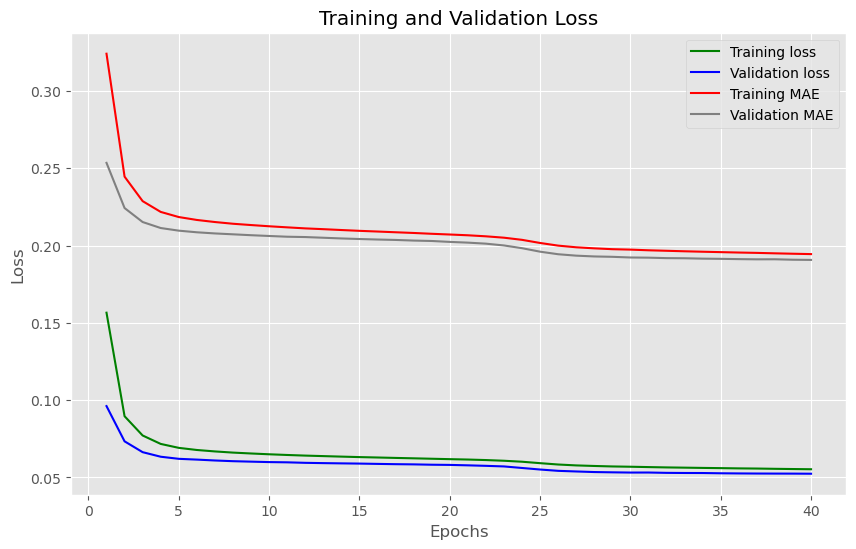

In [8]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
acc = history_dict['mean_absolute_error']
val_acc = history_dict['val_mean_absolute_error']

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'g', label='Training loss')  # 'bo' gives blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')  # 'b' gives solid blue line
plt.plot(epochs, acc, 'r', label='Training MAE')  # 'ro' gives red dots
plt.plot(epochs, val_acc, 'grey', label='Validation MAE')  # 'r' gives solid red line

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()